# Churn Analytics
## Time to churn

A customer churns at the point they stop being a customer whether by withdrawing from the service, or no longer renewing their subscription/making payments. It's easier to retain existing customers than to acquire new ones. Hence, it is important to know which customers are likely to churn and when they might do so. Furthermore, a significant portion of customers are loyal and churn after such a long time (years), that for short term purposes they don’t churn. This is a cure rate survival analysis problem where the event is churning, the time to event is time since acquisition/renewal of subscription, and the cured proportion corresponds to those who never face the event and do not churn. 


## The churn dataset

Below we apply apd-crs to the Telco dataset from Kaggle.com. To save time, we preprocessed it. 



In [1]:
import sys
import os
_ = os.getcwd()

two_up =  os.path.abspath(os.path.join(_,"../.."))
#data_path = os.path.abspath(os.path.join(_,"../../../data"))
sys.path.append(two_up+'/src/apd_crs')

In [2]:
pwd

'/mnt/c/Users/Nem Kosovalic/Desktop/apd-crs/docs/tutorials'

In [73]:
import pandas as pd 
import numpy as np
data = pd.read_csv('telco_preprocessed_full.csv')

In [74]:
data

,customerID,Female,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1.0,0,1.0,NaN,1,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,29.85,29.85,0
1,5575-GNVDE,NaN,0,NaN,NaN,34,1.0,NaN,1.0,NaN,...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,56.95,1889.50,0
2,3668-QPYBK,NaN,0,NaN,NaN,2,1.0,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,53.85,108.15,1
3,7795-CFOCW,NaN,0,NaN,NaN,45,NaN,NaN,1.0,NaN,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,42.30,1840.75,0
4,9237-HQITU,1.0,0,NaN,NaN,2,1.0,NaN,NaN,1.0,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,NaN,0,1.0,1.0,24,1.0,1.0,1.0,NaN,...,1.0,NaN,1.0,NaN,1.0,NaN,NaN,84.80,1990.50,0
7039,2234-XADUH,1.0,0,1.0,1.0,72,1.0,1.0,NaN,1.0,...,1.0,NaN,1.0,NaN,NaN,NaN,1.0,103.20,7362.90,0
7040,4801-JZAZL,1.0,0,1.0,1.0,11,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,29.60,346.45,0
7041,8361-LTMKD,NaN,1,1.0,NaN,4,1.0,1.0,NaN,1.0,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,74.40,306.60,1


## Data Preprocessing


In [75]:
#Data Prep
data = data.drop(columns=["customerID"])
data = data.fillna(0)
data["tenure"] = data["tenure"] / 12


In [76]:
#Relabl: 2="censored" and 1="not cured"

def convert(row):
    if row==0:
        return 2
    return 1

data['Churn'] = data['Churn'].apply(lambda x:convert(x) ) 

In [77]:
#Test train split
from sklearn.model_selection import train_test_split
training_data, test_data, training_labels, test_labels, training_times, test_times = train_test_split(
    data.drop(columns=['Churn', 'tenure']), data['Churn'], data['tenure'], test_size=0.33)


In [78]:
#Scale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
training_data = scaler.fit_transform(training_data)
test_data = scaler.transform(test_data)


## Using the SurvivalAnalysis class

In [79]:
#Instantiate the SurvivalAnalysis class
from survival_analysis import SurvivalAnalysis

In [80]:
model = SurvivalAnalysis()
model.pu_fit_rs(training_data, training_labels, max_guesses=100000)
model.survival_fit(training_data, training_labels, training_times)


/home/nemk/.local/lib/python3.8/site-packages/apd_crs/_validate.py:121: UserWarning: Obtained censoring/cure times in training data that are close to zero. These values will be dropped from training set
  warnings.warn("Obtained censoring/cure times in training data that "
/home/nemk/.local/lib/python3.8/site-packages/apd_crs/_survival_func.py:303: RuntimeWarning: Training data should be scaled appropriately to ensure numerical convergence
  warnings.warn("Training data should be scaled appropriately to ensure numerical "
/home/nemk/.local/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


## Evaluation metrics



### Danger (aka Risk)

The Hazard for susceptible (noncured) individuals is given by

$h(t, x, \gamma) = {\mbox{Baseline Hazard}}(t)\exp(\gamma x)$ 

where 

$\gamma, x = \mbox{covariate weight vector}, \mbox{covariate vector}.$

This motivates us to define the danger associated with an individual having covariate vector $x$ as

$\mbox{Danger}(x) = w_1 (\gamma\cdot x )+ w_2 (1-\pi(x))$ 

where $w_1, w_2\in [0,1]$, $w_1+w_2=1$, and $\pi(x)$ is the probability of cure. 

Optimal weights can be chosen through cross validation.

### Concordance Index (C-Index)

Two individuals are comparable if one experiences the event before the other. 

A pair of individuals is concordant if the one which "died" first has a higher danger.

C-Index = ratio of concordant pairs to comparable pairs.

Clearly C-index is in $[0,1]$ and the higher the better. 

Random guessing $\Rightarrow$ C-index = 0.5

In [81]:
train_danger = (np.dot(training_data, model.gamma_) + np.log(model.predict_cure_proba(training_data,training_labels)[:,1]))

In [82]:
test_danger = (np.dot(test_data, model.gamma_) + np.log(model.predict_cure_proba(test_data, test_labels)[:,1]))

In [83]:
#We can check for correlation with the hazard for the susceptibles (not cured) are probability of being susceptible
np.corrcoef(model.predict_cure_proba(training_data, training_labels)[:,1], np.dot(training_data, model.gamma_))

array([[1.        , 0.65472373],
       [0.65472373, 1.        ]])

## Evaluating Model Performance

### The C-Index

In [92]:
train_score = model.cindex(training_times, training_labels, train_danger) #Uses exp(gamma x) as risk

print(f"c-index score on train set is {train_score}")

c-index score on train set is (0.8125286695827492, 3280481, 756887, 12, 94180)


In [93]:
test_score = model.cindex(test_times, test_labels, test_danger) #Uses exp(gamma x) as risk

print(f"c-index score on test set is {test_score}")

c-index score on test set is (0.8128951556439341, 769760, 177176, 1, 19670)


### Overall Risk factors

<AxesSubplot:>

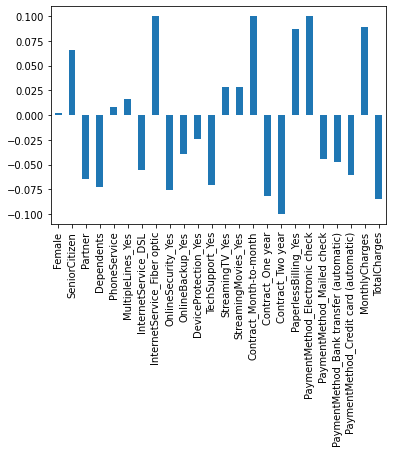

In [88]:
features = [col for col in data.columns if col not in ['Churn', 'tenure']]
feats = {col:model.gamma_[i] for (i,col) in enumerate(features)}
feats = pd.Series(feats)
feats.plot.bar()

### Individual Predictions

In [90]:
#Overall survivor function:

#We can plot the overall survival function for e.g. the first five indiduals in the test set.

TIMES = np.arange(1, 93, 0.05)
repeats_array = np.tile(TIMES, (len(test_data), 1))
ovpr = model.predict_overall_survival(test_data, repeats_array, test_labels)

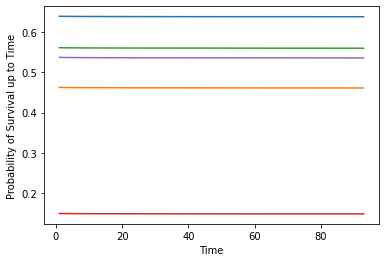

In [91]:
import matplotlib.pyplot as plt
y = ovpr[0:5,:]
x = TIMES
plt.plot(x, y.T, )
plt.xlabel('Time')
plt.ylabel('Probability of Survival up to Time')
plt.show()

In [18]:
#Corresponding probabilities of cure:

for i in range(5):
   print(f'The cure probability of individual {i} is: {(model.predict_cure_proba(test_data, test_labels)[0:5,0])[i]}')

The cure probability of individual 0 is: 0.6306985335465067
The cure probability of individual 1 is: 0.9351001991992633
The cure probability of individual 2 is: 0.4210536941745374
The cure probability of individual 3 is: 0.5134855344882093
The cure probability of individual 4 is: 0.605773010511532
